# LPS and LCS in Tryptic Peptides

In [1]:
include("source/utils.jl")
include("source/expectation.jl")
include("source/mask.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/palindrome.jl")
include("source/trypsin.jl")
using Plots
using DataFrames
using DelimitedFiles
using StatsBase
newLPSdist() = zeros(Int, (maxlength, maxlength))
newLCSdist() = zeros(Int, (maxlength + 1, maxlength + 1))

newLCSdist (generic function with 1 method)

In [2]:
shuf_sprot = readsequences("data/shuf_sprot.fa")
sprot = readsequences("data/sprot.fa")
masked_sprot = hardmask.(readsequences("data/masked_sprot.fa"))
masked_sprot = replace.(masked_sprot, 'X'=>"")
minlength = 5
maxlength = 100;

### Generate LPS distributions of tryptic peptides

In [3]:
function tryptic_lps(
    protein::String; 
    lo=minlength,
    hi=maxlength,
)
    tryptics = trypticpeptide(protein, lo, hi)
    sequencelength = (length(seq) for seq=tryptics)
    lps = (length(longestpalindromicsubstring(seq)) for seq=tryptics)
    return zip(sequencelength, lps)
end
function tryptic_lps(
    proteins::Vector;
    lo=minlength,
    hi=maxlength
)
    distribution = zeros(Int, (maxlength, maxlength))
    P = Progress(length(proteins), 1)
    Threads.@threads for p=proteins
        for (x,y)=tryptic_lps(p)
            distribution[x, y] += 1
        end
        next!(P)
    end
    distribution
end

tryptic_lps (generic function with 2 methods)

In [4]:
function tryptic_shuf_lcs(
    protein::String; 
    lo=minlength,
    hi=maxlength,
)
    tryptics = trypticpeptide(protein, lo, hi)
    sequencelength = (length(seq) for seq=tryptics)
    shuf_tryptics = (shufflefast(seq) for seq=tryptics)
    lcs = (length(longestcommonsubstring(seq1, seq2)[begin]) 
        for (seq1,seq2)=zip(tryptics,shuf_tryptics))
    return zip(sequencelength, lcs)
end
function tryptic_shuf_lcs(
    proteins::Vector;
    lo=minlength,
    hi=maxlength
)
    distribution = zeros(Int, (maxlength, maxlength))
    P = Progress(length(proteins), 1)
    Threads.@threads for p=proteins
        for (x,y)=tryptic_shuf_lcs(p)
            distribution[x, y] += 1
        end
        next!(P)
    end
    distribution
end

tryptic_shuf_lcs (generic function with 2 methods)

In [15]:
function tryptic_shuf_lps(
    protein::String; 
    lo=minlength,
    hi=maxlength,
)
    tryptics = trypticpeptide(protein, lo, hi)
    sequencelength = (length(seq) for seq=tryptics)
    shuf_tryptics = (shufflefast(seq) for seq=tryptics)
    shuf_lps = (length(longestpalindromicsubstring(seq)) for seq=shuf_tryptics)
    return zip(sequencelength, shuf_lps)
end
function tryptic_shuf_lps(
    proteins::Vector;
    lo=minlength,
    hi=maxlength
)
    distribution = zeros(Int, (maxlength, maxlength))
    P = Progress(length(proteins), 1)
    Threads.@threads for p=proteins
        for (x,y)=tryptic_shuf_lps(p)
            distribution[x, y] += 1
        end
        next!(P)
    end
    distribution
end

tryptic_shuf_lps (generic function with 2 methods)

In [16]:
shuf_lcs = tryptic_shuf_lcs(sprot)
writetable("outputs/tryptic.sprot_shuf-sprot.lcs", shuf_lcs)

Progress: 100%|█████████████████████████████████████████| Time: 0:35:41


In [17]:
shuf_lps = tryptic_lps(shuf_sprot)
writetable("outputs/tryptic.shuf-sprot.lps", shuf_lps)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


In [18]:
masked_lps = tryptic_lps(masked_sprot)
writetable("outputs/tryptic.masked-sprot.lps", masked_lps)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:38                                              


In [19]:
sprot_lps = tryptic_lps(sprot)
writetable("outputs/tryptic.sprot.lps", sprot_lps)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:29


In [20]:
shuf2_lps = tryptic_shuf_lps(sprot)
writetable("outputs/tryptic.shuf2-sprot.lps", shuf2_lps)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:20


# Plot [python]

In [1]:
import matplotlib
matplotlib.__version__

'3.7.2'

In [2]:
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics as stats
from math import *
from time import time
def plot_x_means(axis, distributions, minlength, maxlength, color, marker, label, width=10):
    x = list(range(1,maxlength+1))
    y = [-1 for _ in range(maxlength)]
    for i in range(minlength-1,maxlength):
        D = distributions[i]
        y[i] = sum([D[j]*(j+1) for j in range(maxlength)]) / sum(D)
    x = x[minlength:maxlength]
    y = y[minlength:maxlength]
    axis.plot(x, y, linewidth=10, label=label, color=color)
def setup_axis(axis,xlo=5,xhi=100,ylo=1.5,yhi=5,legsize=100):
    axis.set_xlim(xlo,xhi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length", fontsize=100, labelpad=30)
    axis.set_ylim(ylo,yhi)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length", fontsize=100, labelpad=50)
    axis.tick_params(axis='both', which='major', labelsize=50)
    leg = axis.legend(prop={'size':legsize})
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        lh.set_linewidth(10)

In [3]:
resultpaths = ["outputs/tryptic.sprot_shuf-sprot.lcs",
    "outputs/tryptic.shuf-sprot.lps",
    "outputs/tryptic.shuf2-sprot.lps",
    "outputs/tryptic.sprot.lps",
    "outputs/tryptic.masked-sprot.lps"]
(lcs_shuf,
 lps_shuf,
 lps_shuf2,
 lps_sprot,
 lps_masked_sprot) = [pd.read_csv(x, sep='\t', header=None).values for x in resultpaths]
lcsmaroon = "#8a1414"
sprotblue = "#0000ff"
shufred = "#ff8800"
maskgreen = maskblue = "#228FAF"

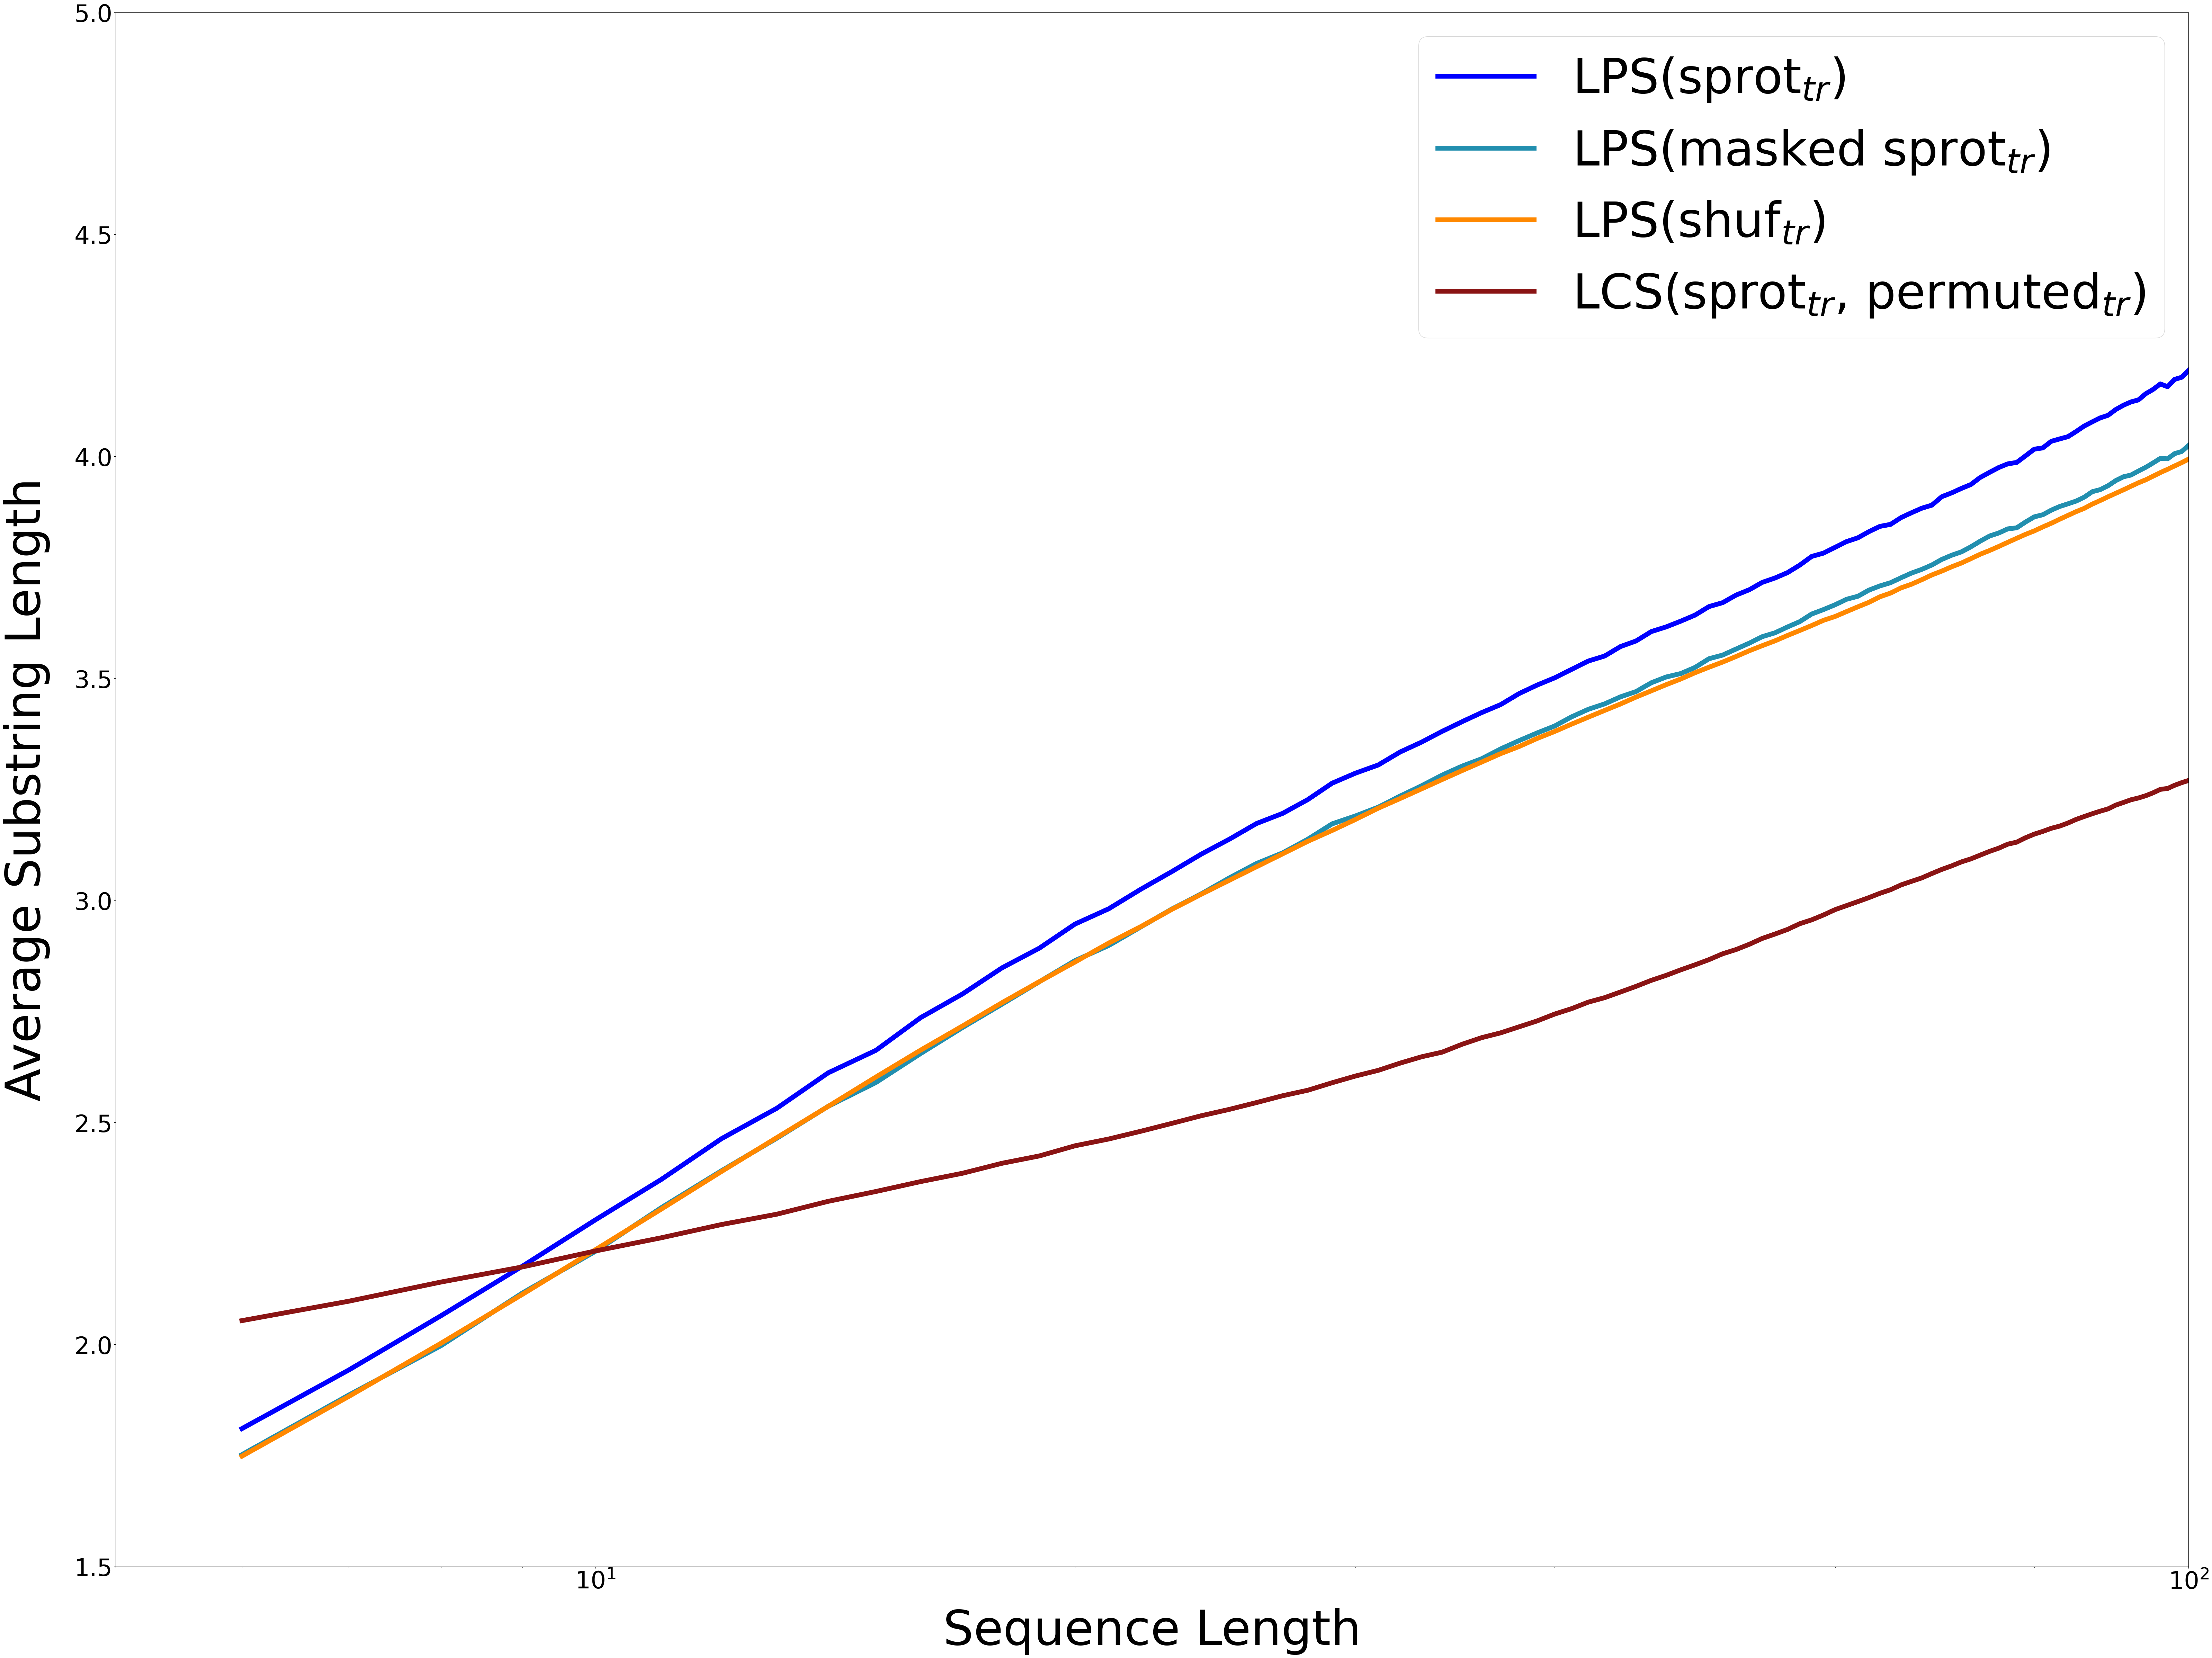

In [4]:
fig, ax = plt.subplots(dpi=100,figsize=(64,48))

plot_x_means(ax, lps_sprot, 5, 100,
                      sprotblue, '^', "LPS(sprot$_{tr}$)")
plot_x_means(ax, lps_masked_sprot, 5, 100,
                      maskgreen, 'x', "LPS(masked sprot$_{tr}$)")
plot_x_means(ax, lps_shuf, 5, 100,
                      shufred, 's', "LPS(shuf$_{tr}$)")
plot_x_means(ax, lcs_shuf, 5, 100,
                      lcsmaroon, 'o', "LCS(sprot$_{tr}$, permuted$_{tr}$)")

setup_axis(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_TrypticPeptides2.pdf")

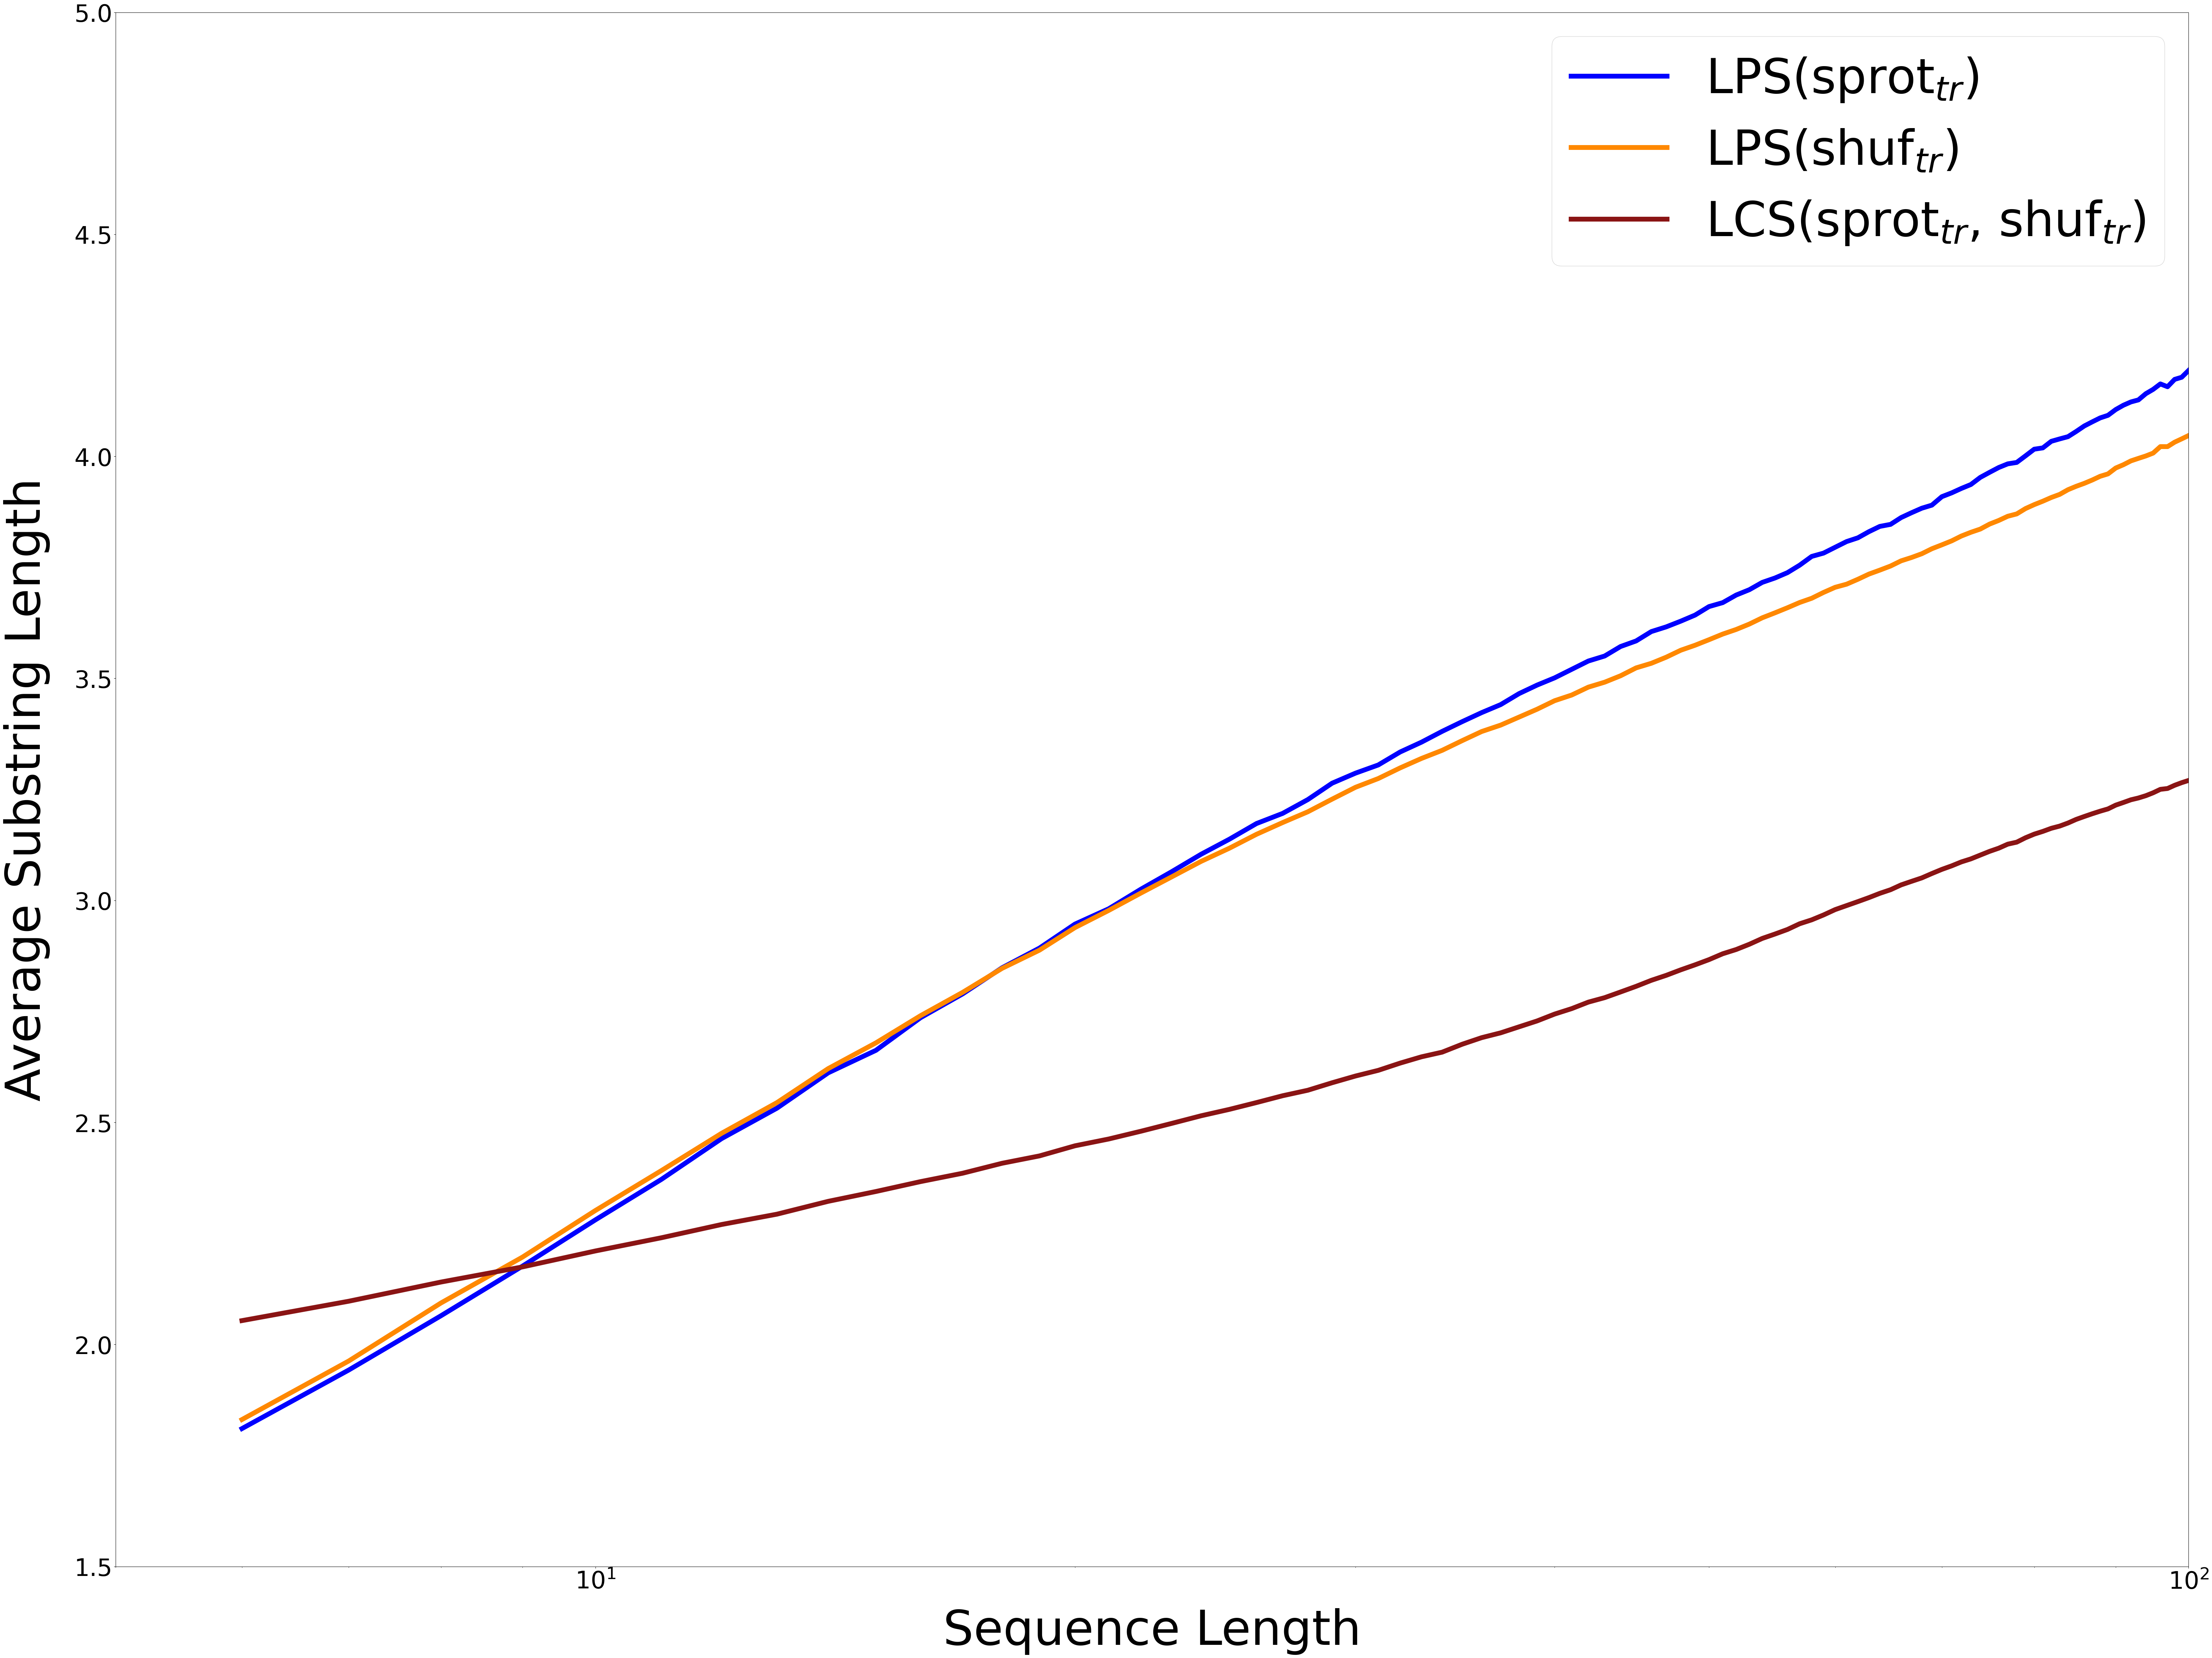

In [5]:
fig, ax = plt.subplots(dpi=100,figsize=(64,48))

plot_x_means(ax, lps_sprot, 5, 100,
                      sprotblue, '^', "LPS(sprot$_{tr}$)")
plot_x_means(ax, lps_shuf2, 5, 100,
                      shufred, 's', "LPS(shuf$_{tr}$)")
plot_x_means(ax, lcs_shuf, 5, 100,
                      lcsmaroon, 'o', "LCS(sprot$_{tr}$, shuf$_{tr}$)")

setup_axis(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_TrypticPeptides2.pdf")